In [206]:
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.spatial.distance import pdist, squareform,cdist
from scipy.cluster.vq import kmeans2
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd

In [207]:

class DBSCAN:
    def __init__(self, epsilon, minPts):
        self.epsilon = epsilon
        self.minPts = minPts
        self.labels = None
        self.data_frame = None

    def fit(self, X, distance_matrix):
        num_points = distance_matrix.shape[0]
        visited = np.zeros(num_points, dtype=bool)
        self.labels = np.zeros(num_points, dtype=int)
        cluster_label = 0
        output = []
        point_coordinates = np.array([[x, y] for x, y in zip(X[:, 0], X[:, 1])])

        for i in range(num_points):
            if visited[i]:
                continue

            visited[i] = True
            neighbors = self.region_query(i, distance_matrix)

            if len(neighbors) < self.minPts:
                self.labels[i] = -1
            else:
                cluster_label += 1
                self.expand_cluster(i, neighbors, cluster_label, visited, distance_matrix)

        for i in range(num_points):
            neighbor_indices = [str(x) for x in self.region_query(i, distance_matrix)]
            output.append([i, point_coordinates[i, 0], point_coordinates[i, 1], len(neighbor_indices), ','.join(neighbor_indices)])

        self.data_frame = pd.DataFrame(output, columns=["pt", "x", "y", "num_neighbors", "neighbors"])

    def expand_cluster(self, point_index, neighbors, cluster_label, visited, distance_matrix):
        self.labels[point_index] = cluster_label

        while len(neighbors) > 0:
            current_point = neighbors[0]
            neighbors = neighbors[1:]

            if not visited[current_point]:
                visited[current_point] = True
                current_neighbors = self.region_query(current_point, distance_matrix)

                if len(current_neighbors) >= self.minPts:
                    neighbors.extend(current_neighbors)

            if self.labels[current_point] == 0:
                self.labels[current_point] = cluster_label

    def region_query(self, point_index, distance_matrix):
        neighbors = []
        for i, distance in enumerate(distance_matrix[point_index]):
            if distance <= self.epsilon:
                neighbors.append(i)
        return neighbors

In [208]:
data_ds = pd.read_csv('moons.csv')
data_ds.columns = ['x', 'y']
data_ds.head()

,x,y
0,-0.378142,0.940750
1,0.933566,0.153805
2,2.048309,0.498172
3,0.947891,0.162473
4,2.000739,0.183700


In [209]:
#compute the distance matrix
matrix_ward = linkage(data_ds, method='ward',metric='euclidean')
matrix_single = linkage(data_ds, method='single',metric='euclidean')



# Calculate the distance matrix using the desired distance metric 
dbscan_distance_matrix = cdist(data_ds, data_ds, metric='euclidean')

In [210]:
X=data_ds.to_numpy()
# initializing the the model
dbscan = DBSCAN(epsilon=7.5, minPts=3)
dbscan.fit(X,dbscan_distance_matrix)

In [ ]:
dbscan.labels

array([1, 2, 3, ..., 3, 1, 1])

In [ ]:
# obtan cluster labels
labels_ward = fcluster(matrix_ward,2, criterion='maxclust')
labels_single = fcluster(matrix_single,2, criterion='maxclust')
centroids_kmeans,labels_kmeans = kmeans2(data_ds, 2, minit='points')

In [ ]:
data_ds['labels_kmeans'] = labels_kmeans
data_ds['labels_ward'] = labels_ward
data_ds['labels_single'] = labels_single
data_ds['labels_dbscan'] = dbscan.labels

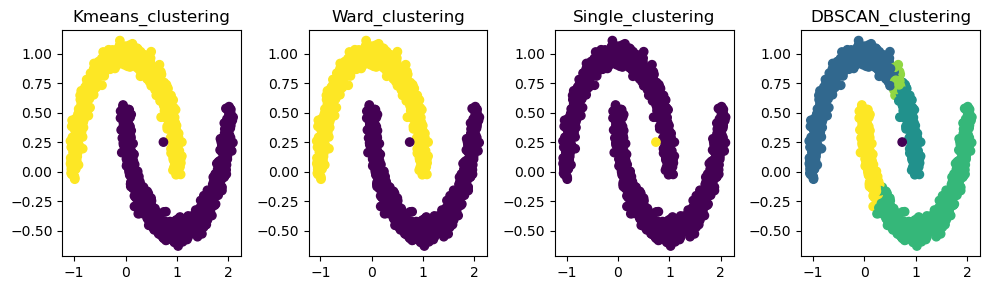

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(10,3))
ax[0].scatter(data_ds['x'],data_ds['y'],c=data_ds['labels_kmeans'])
ax[0].title.set_text('Kmeans_clustering')

ax[1].scatter(data_ds['x'],data_ds['y'],c=data_ds['labels_ward'])
ax[1].title.set_text('Ward_clustering')

ax[2].scatter(data_ds['x'],data_ds['y'],c=data_ds['labels_single'])
ax[2].title.set_text('Single_clustering')

ax[3].scatter(data_ds['x'],data_ds['y'],c=data_ds['labels_dbscan'])
ax[3].title.set_text('DBSCAN_clustering')

fig.tight_layout()

plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

# Create an instance of the DBSCAN class
dbscan = DBSCAN(eps=0.1, min_samples=1)

# Fit the DBSCAN model to your data
dbscan.fit(X)

# Retrieve the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Retrieve the core samples (points that are not considered outliers)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Print the cluster labels and core samples
print("Cluster labels:", labels)
print("Core samples mask:", core_samples_mask)


Cluster labels: [0 0 1 ... 1 0 0]
Core samples mask: [ True  True  True ...  True  True  True]


Text(0.5, 1.0, 'DBSCAN_clustering')

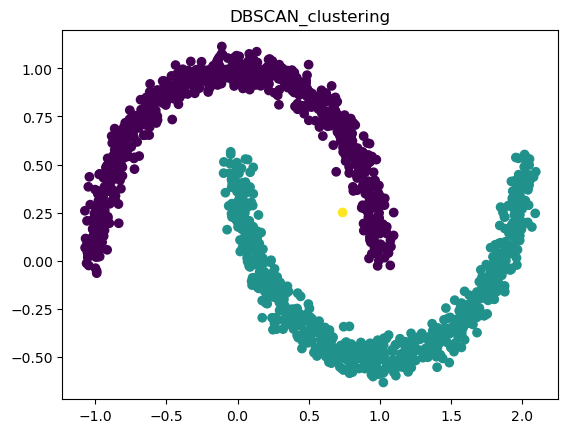

In [ ]:
data_ds['sklearn_dbscan'] = labels


plt.scatter(data_ds['x'],data_ds['y'],c=data_ds['sklearn_dbscan'])
plt.title('DBSCAN_clustering')